In [1]:
import csv
import numpy as np
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

% matplotlib inline
from matplotlib import pyplot as plt

import urllib.request
from lxml import etree

##### Load from csv files

In [2]:
# data here: https://docs.google.com/spreadsheets/d/1LzfXHU-wdNUQ-NnFZvBIYMVgvGR1YCI4K8GFVZNraEc
attendance_csvfile = open("ACL statistics - Attendance.csv")
attendance_reader = csv.reader(attendance_csvfile)
attendance = [[item for item in row] for row in attendance_reader]

talks_csvfile = open("ACL statistics - Talks.csv")
talks_reader = csv.reader(talks_csvfile)
talks_raw = [[item for item in row] for row in talks_reader]
talks = np.array(talks_raw)#[:-1,:-1]
best_paper_talks = np.array(talks_raw)[1:,-1:]

list_of_atten = list(np.array(attendance).flatten())
list_of_talks = [talk for sess in talks for talk in sess]

# source: https://twitter.com/zkozareva/status/1019455751784288259
honorable_mentions = """Jointly Predicting Predicates and Arguments in Neural Semantic Role Labeling
Do Neural Network Cross-Modal Mappings Really Bridge Modalities?
Coarse-to-Fine Decoding for Neural Semantic Parsing
NASH: Toward End-to-End Neural Architecture for Generative Semantic Hashing
Backpropagating through Structured Argmax using a SPIGOT
Hierarchical Neural Story Generation
Semantically Equivalent Adversarial Rules for Debugging NLP models
Large-Scale QA-SRL Parsing""".split('\n')

best_paper_topics = [
    'Question Answering', # Know What You Don’t Know: Unanswerable Questions for SQuAD
    'Semantics', # 'Lighter' Can Still Be Dark: Modeling Comparative Color Descriptions
    'Linguistics, Psycholinguistics and Cognitive Modeling', # Finding syntax in human encephalography with beam search
    'Information Extraction', # Learning to Ask Good Questions: Ranking Clarification Questions using Neural Expected Value of Perfect Information
    'Word Semantics', # Let's do it ``again'': A First Computational Approach to Detecting Adverbial Presupposition Triggers
]
best_to_topic = dict(zip(best_paper_talks.flatten(), best_paper_topics))

##### Crawl from the Internet

In [3]:
req = urllib.request.Request("https://acl2018.org/programme/schedule/")
response = urllib.request.urlopen(req)
the_page = response.read()
tree = etree.HTML(the_page)
poster_presentations = tree.xpath("//span[contains(@class,'poster-name searchable')]")
talk_presentations = tree.xpath("//div[contains(@class,'talk searchable')]")

presentations = []
sessions = Counter()
for div in talk_presentations:
    is_tacl = False
    raw_data = div.attrib['data-index'].strip()
    authors, abstract = div.attrib['title'].split('. ABSTRACT: ')
    session_id = div.attrib['id'].split('-')[1]
    uri = div.getchildren()[1].getchildren()[1].attrib['href']
    title = div.getchildren()[1].getchildren()[1].text
    if title is None:
        is_tacl = True
        title = div.getchildren()[1].getchildren()[1].attrib['title'][len("view '"):-len("' on TransACL site if it is already published")]
    
    paper_id = raw_data.split()[0]
    session_title = raw_data.split(' session ')[-1]
    session_title = session_title[4:].strip()
    session_title = session_title if not is_tacl else session_title[:-4].strip()
        
    sessions[session_id]+=int(list_of_atten[list_of_talks.index(title)])
    
    presentations.append({
        'session': session_title if len(session_title.split()[-1]) > 1 else session_title[:-2],
        'session_id': session_id,
        'id': paper_id,
        'uri': uri,
        'title': title,
        'authors': [a.strip() for _authors in authors.split(';') for a in _authors.split(',')],
        'abstract': abstract,
        'attendees': int(list_of_atten[list_of_talks.index(title)]),
        'is_oral': True,
        'is_tacl': is_tacl,
        'is_tutorial': False
    })

for session_id in sessions:
    for p in presentations:
        if p['session_id'] == session_id:
            p['attendance_rate'] = p['attendees']/sessions[session_id]
            
    
for span in poster_presentations:
    is_tacl = False
    is_tutorial = False
    raw_data = span.attrib['data-index'].strip()
    authors, abstract = span.attrib['title'].split('. ABSTRACT: ')
    uri = span.getchildren()[1].attrib['href']
    title = span.getchildren()[1].text
    if title is None:
        is_tacl = True
        title = span.getchildren()[1].attrib['title'][len("view '"):-len("' on TransACL site if it is already published")]
    
    paper_id = raw_data.split()[0]
    session_title = raw_data.split(' session ')[-1]
    if len(raw_data.split(' session ')) == 1:
        is_tutorial = True
    else:
        session_title = session_title[4:].strip()
        session_title = session_title if not is_tacl else session_title[:-4].strip()
    
    presentations.append({
        'uri': uri,
        'session': session_title if len(session_title.split()[-1]) > 1 else session_title[:-2],
        'id': paper_id,
        'title': title,
        'authors': authors.split(';'),
        'abstract': abstract,
        'is_oral': False,
        'is_tacl': is_tacl,
        'is_tutorial': is_tutorial
    })

In [4]:
from IPython.display import display, Markdown
display_list_of_best_papers = ''
for p in presentations:
    if p['session'] == 'best paper session':
        display_list_of_best_papers += '- *[{title}](https://acl2018.org{uri})*. {authors}. `{session}`\n'.format(
            rate=p['attendance_rate'],
            title=p['title'].replace('*', '&#42; ').replace('\&', '&amp;').replace('``', '"').replace("''", '"'),
            uri=p['uri'],
            authors=', '.join(p['authors']),
            session=best_to_topic[p['title']].lower()
        )

display_list_of_honorable_mentions = ''
for p in presentations:
    if p['title'] in honorable_mentions:
        display_list_of_honorable_mentions += '- *[{title}](https://acl2018.org{uri})*. {authors}. `{session}`\n'.format(
            rate=p['attendance_rate'],
            title=p['title'].replace('*', '&#42; ').replace('\&', '&amp;').replace('``', '"').replace("''", '"'),
            uri=p['uri'],
            authors=', '.join(p['authors']),
            session=p['session']
        )

display_list_of_highly_attended = ''
for p in presentations:
    if 'attendance_rate' in p and (p['attendance_rate'] > 1/3 or p['attendees'] >= 100) and p['session'] != 'best paper session':
        display_list_of_highly_attended += '- *[{title}](https://acl2018.org{uri})*. {authors}. `{session}`\n'.format(
            rate=p['attendance_rate'],
            title=p['title'].replace('*', '&#42; ').replace('\&', '&amp;').replace('``', '"').replace("''", '"'),
            uri=p['uri'],
            authors=', '.join(p['authors']),
            session=p['session']
        )


display(Markdown('#### Best papers:'))
display(Markdown(display_list_of_best_papers))

display(Markdown('#### Honorable mentions at the closing session:'))
display(Markdown(display_list_of_honorable_mentions))

display(Markdown('#### At least 100 attendees or 1/3 of attendees on each session preferred these talks:'))
display(Markdown(display_list_of_highly_attended))


#### Best papers:

- *[Know What You Don’t Know: Unanswerable Questions for SQuAD](https://acl2018.org/paper/1125)*. Pranav Rajpurkar, Robin Jia, Percy Liang. `question answering`
- *['Lighter' Can Still Be Dark: Modeling Comparative Color Descriptions](https://acl2018.org/paper/1603)*. Olivia Winn, Smaranda Muresan. `semantics`
- *[Finding syntax in human encephalography with beam search](https://acl2018.org/paper/618)*. John Hale, Chris Dyer, Adhiguna Kuncoro, Jonathan Brennan. `linguistics, psycholinguistics and cognitive modeling`
- *[Learning to Ask Good Questions: Ranking Clarification Questions using Neural Expected Value of Perfect Information](https://acl2018.org/paper/1247)*. Sudha Rao, Hal Daumé III. `information extraction`
- *[Let's do it "again": A First Computational Approach to Detecting Adverbial Presupposition Triggers](https://acl2018.org/paper/1348)*. Andre Cianflone, Yulan Feng, Jad Kabbara, Jackie Chi Kit Cheung. `word semantics`


#### Honorable mentions at the closing session:

- *[Coarse-to-Fine Decoding for Neural Semantic Parsing](https://acl2018.org/paper/434)*. Li Dong, Mirella Lapata. `semantic parsing`
- *[Semantically Equivalent Adversarial Rules for Debugging NLP models](https://acl2018.org/paper/1406)*. Marco Tulio Ribeiro, Sameer Singh, Carlos Guestrin. `question answering`
- *[Hierarchical Neural Story Generation](https://acl2018.org/paper/1251)*. Angela Fan, Mike Lewis, Yann Dauphin. `generation`
- *[Jointly Predicting Predicates and Arguments in Neural Semantic Role Labeling](https://acl2018.org/paper/881)*. Luheng He, Kenton Lee, Omer Levy, Luke Zettlemoyer. `semantics`
- *[Do Neural Network Cross-Modal Mappings Really Bridge Modalities?](https://acl2018.org/paper/1549)*. Guillem Collell, Marie-Francine Moens. `vision, linguistics, resource and evaluation`
- *[Backpropagating through Structured Argmax using a SPIGOT](https://acl2018.org/paper/1248)*. Hao Peng, Sam Thomson, Noah A. Smith. `machine learning`
- *[NASH: Toward End-to-End Neural Architecture for Generative Semantic Hashing](https://acl2018.org/paper/1022)*. Dinghan Shen, Qinliang Su, Paidamoyo Chapfuwa, Wenlin Wang, Guoyin Wang, Ricardo Henao, Lawrence Carin. `information retrieval`
- *[Large-Scale QA-SRL Parsing](https://acl2018.org/paper/1498)*. Nicholas FitzGerald, Julian Michael, Luheng He, Luke Zettlemoyer. `semantic parsing`


#### At least 100 attendees or 1/3 of attendees on each session preferred these talks:

- *[Probabilistic FastText for Multi-Sense Word Embeddings](https://acl2018.org/paper/187)*. Ben Athiwaratkun, Andrew Wilson, Anima Anandkumar. `word semantics`
- *[A La Carte Embedding: Cheap but Effective Induction of Semantic Feature Vectors](https://acl2018.org/paper/1520)*. Mikhail Khodak, Nikunj Saunshi, Yingyu Liang, Tengyu Ma, Brandon Stewart, Sanjeev Arora. `word semantics`
- *[The Best of Both Worlds: Combining Recent Advances in Neural Machine Translation](https://acl2018.org/paper/1011)*. Mia Xu Chen, Orhan Firat, Ankur Bapna, Melvin Johnson, Wolfgang Macherey, George Foster, Llion Jones, Mike Schuster, Noam Shazeer, Niki Parmar, Ashish Vaswani, Jakob Uszkoreit, Lukasz Kaiser, Zhifeng Chen, Yonghui Wu, Macduff Hughes. `machine translation`
- *[Hierarchical Neural Story Generation](https://acl2018.org/paper/1251)*. Angela Fan, Mike Lewis, Yann Dauphin. `generation`
- *[Unsupervised Discrete Sentence Representation Learning for Interpretable Neural Dialog Generation](https://acl2018.org/paper/298)*. Tiancheng Zhao, Kyusong Lee, Maxine Eskenazi. `dialog system`
- *[Exemplar Encoder-Decoder for Neural Conversation Generation](https://acl2018.org/paper/1538)*. Gaurav Pandey, Danish Contractor, Vineet Kumar, Sachindra Joshi. `dialog system`
- *[The Hitchhiker’s Guide to Testing Statistical Significance in Natural Language Processing](https://acl2018.org/paper/703)*. Rotem Dror, Gili Baumer, Segev Shlomov, Roi Reichart. `evaluation`
- *[LSTMs Can Learn Syntax-Sensitive Dependencies Well, But Modeling Structure Makes Them Better](https://acl2018.org/paper/1175)*. Adhiguna Kuncoro, Chris Dyer, John Hale, Dani Yogatama, Stephen Clark, Phil Blunsom. `parsing`
- *[Training Classifiers with Natural Language Explanations](https://acl2018.org/paper/1335)*. Braden Hancock, Paroma Varma, Stephanie Wang, Martin Bringmann, Percy Liang, Christopher Ré. `machine learning`
- *[Did the Model Understand the Question?](https://acl2018.org/paper/1159)*. Pramod Kaushik Mudrakarta, Ankur Taly, Mukund Sundararajan, Kedar Dhamdhere. `question answering`
- *[What you can cram into a single \$&amp;!#&#42;  vector: Probing sentence embeddings for linguistic properties](https://acl2018.org/paper/891)*. Alexis Conneau, Germán Kruszewski, Guillaume Lample, Loïc Barrault, Marco Baroni. `language/document model`
- *[Zero-Shot Transfer Learning for Event Extraction](https://acl2018.org/paper/450)*. Lifu Huang, Heng Ji, Kyunghyun Cho, Ido Dagan, Sebastian Riedel, Clare Voss. `information extraction`
- *[Exploring Semantic Properties of Sentence Embeddings](https://acl2018.org/paper/1483)*. Xunjie Zhu, Tingfeng Li, Gerard de Melo. `semantics`
- *[Extracting Commonsense Properties from Embeddings with Limited Human Guidance](https://acl2018.org/paper/972)*. Yiben Yang, Larry Birnbaum, Ji-Ping Wang, Doug Downey. `semantics`


In [5]:
# shared between two lists:
for p in presentations:
    if p['title'] in honorable_mentions:
        if 'attendance_rate' in p and (p['attendance_rate'] > 1/3 or p['attendees'] >= 100) and p['session'] != 'best paper session':
            display(Markdown('- *[{title}](https://acl2018.org{uri})*. {authors}. `{session}`\n'.format(
                rate=p['attendance_rate'],
                title=p['title'].replace('*', '&#42; ').replace('\&', '&amp;').replace('``', '"').replace("''", '"'),
                uri=p['uri'],
                authors=', '.join(p['authors']),
                session=p['session']
            )))

- *[Hierarchical Neural Story Generation](https://acl2018.org/paper/1251)*. Angela Fan, Mike Lewis, Yann Dauphin. `generation`


### Statistics

In [6]:
top_10s = {}

In [7]:
posters_count = Counter([
    p['session']
    for p in presentations
    if not p['is_oral'] and not p['is_tutorial']
])

attendance_freq = np.array(attendance[1:-1], int)[:,:-1].reshape((4, 8, 6))
attend_per_hour = attendance_freq.sum(2)

attendance_normal = attendance_freq / np.repeat(np.expand_dims(attend_per_hour, 2), 6, 2)

topics = np.array(attendance[0])[:-1].flatten()

honorable_topics = [
    [t for t in topics if p['session'] == t.lower()][0]
    for p in presentations
    if p['title'] in honorable_mentions
]

In [8]:
print(attend_per_hour.max(), 'maximum number of declared attendance')
print(attend_per_hour.min(0).max(), 'max-min number of declared attendance')
print(attend_per_hour.max(0).min(), 'min-max number of declared attendance')
print(attend_per_hour.min(), 'min number of declared attendance')
print(np.mean(attend_per_hour), 'average number of declared attendance')

430 maximum number of declared attendance
342 max-min number of declared attendance
261 min-max number of declared attendance
203 min number of declared attendance
305.0 average number of declared attendance


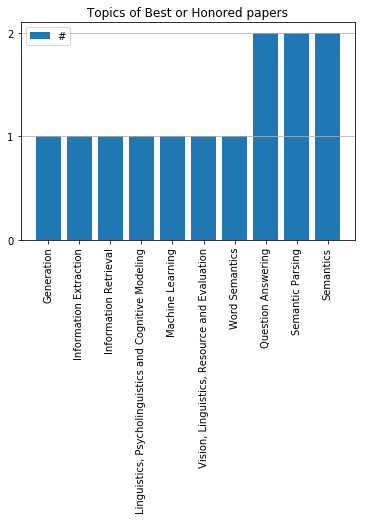

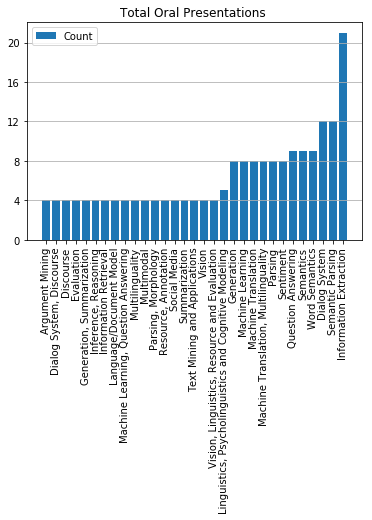

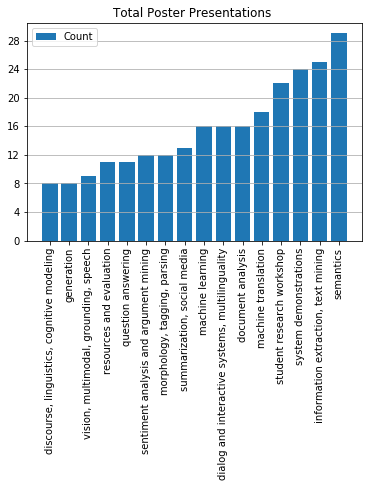

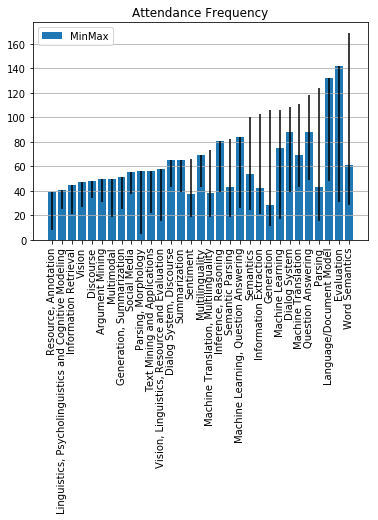

In [9]:
attendance_scores = attendance_freq.reshape((attendance_freq.shape[0],attendance_freq.shape[1]*attendance_freq.shape[2]))
scores = defaultdict(lambda: [])
for i, subject in enumerate(topics):
    scores[subject.strip()].append(attendance_scores[:,i])
    
scores_max = {
    key: np.array(scores[key]).max()
    for key in scores
    if np.max(scores[key]) > 0
}

scores_min = {
    key: np.array(scores[key]).min()
    for key in scores
    if np.max(scores[key]) > 0
}

scores_minmax = {
    key: np.array(scores[key]).max(1).min()
    for key in scores
    if np.max(scores[key]) > 0
}

scores_count = {
    key: np.array(scores[key]).flatten().shape[0] + (1 if key in best_paper_topics else 0)
    for key in scores
    if np.max(scores[key]) > 0
}

scores_best_or_honorable = {
    key: Counter(best_paper_topics + honorable_topics)[key]
    for key in scores
    if np.max(scores[key]) > 0
}

data = np.array([
    [
        scores_max[key], # 0
        scores_minmax[key], # 1
        scores_min[key], # 2
        scores_count[key], # 3
        scores_best_or_honorable[key], # 4
    ]
    for key in sorted(list(scores.keys()))
    if np.max(scores[key]) > 0
])

labels = np.array([
    key
    for key in sorted(list(scores.keys()))
    if np.max(scores[key]) > 0
])

#####
sorted_indices = [i for i, s in sorted(list(enumerate(data[:,4])), key=lambda x: x[1]) if s > 0]
top_10s['In best/honored'] = labels[sorted_indices][data[sorted_indices,4]>0]

plt.bar(
    x=range(len(sorted_indices)),
    height=data[sorted_indices,4],
    label="#",
)

plt.xticks(range(len(sorted_indices)), labels[sorted_indices], rotation=90)
plt.grid(axis='y')
plt.yticks([0, 1, 2])
plt.legend(loc='upper left')
plt.title('Topics of Best or Honored papers')
plt.savefig('best_honorable_count.png',bbox_inches='tight')
plt.show()

#####
sorted_indices = [i for i, _ in sorted(list(enumerate(data[:,3])), key=lambda x: x[1])]
# more than 4 oral presentations:
#top_10s['Papers'] = labels[sorted_indices][data[sorted_indices,3]>8]
top_10s['# Papers > 7'] = labels[sorted_indices][data[sorted_indices,3]>7]

plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,3],
    label="Count",
)

plt.xticks(range(len(data)), labels[sorted_indices], rotation=90)
plt.grid(axis='y')
plt.yticks([0, 4, 8, 12, 16, 20])
plt.legend(loc='upper left')
plt.title('Total Oral Presentations ')
plt.savefig('presentation_count.png',bbox_inches='tight')
plt.show()


#####
_labels, _counts = list(zip(*sorted(posters_count.items(), key=lambda x: x[1])))
plt.bar(
    x=range(len(_counts)),
    height=_counts,
    label="Count",
)
plt.xticks(range(len(_counts)), _labels, rotation=90)
plt.grid(axis='y')
plt.yticks([0, 4, 8, 12, 16, 20, 24, 28])
plt.legend(loc='upper left')
plt.title('Total Poster Presentations ')
plt.savefig('poster_count.png',bbox_inches='tight')
plt.show()

########
sorted_indices = [i for i, _ in sorted(list(enumerate(data[:,0])), key=lambda x: x[1])]
top_10s['Attend # > 100'] = labels[sorted_indices][data[sorted_indices,0]>100]
#labels[sorted_indices[-3:]]

plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,1],
    label="MinMax",
    yerr=(data[sorted_indices,:][:,[1,0]]-data[sorted_indices,:][:,[2,1]]).T
)

plt.xticks(range(len(data)), labels[sorted_indices], rotation=90)
plt.grid(axis='y')
plt.legend(loc='upper left')
plt.title('Attendance Frequency')
plt.savefig('attendance_frequency.png',bbox_inches='tight')
plt.show()


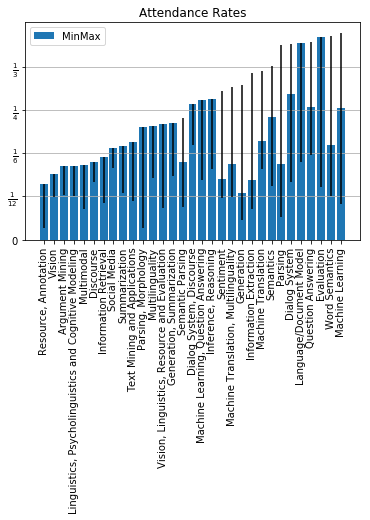

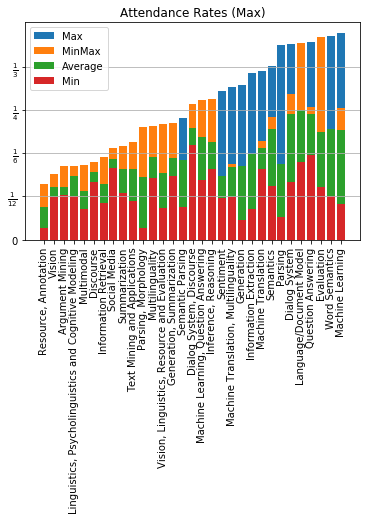

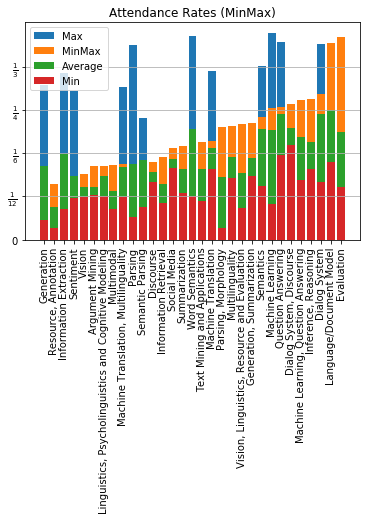

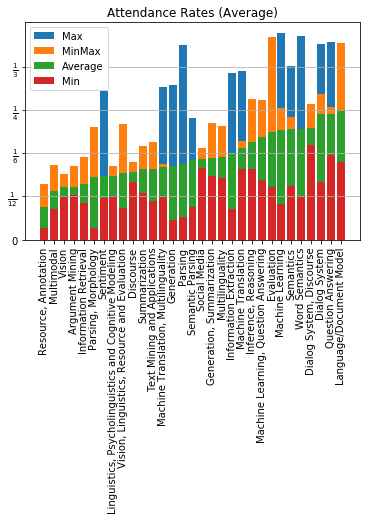

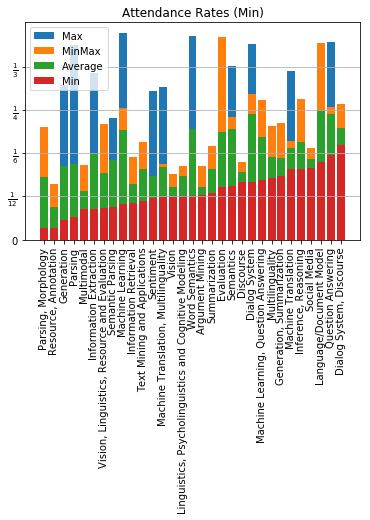

In [10]:
attendance_scores = attendance_normal.reshape((attendance_normal.shape[0],attendance_normal.shape[1]*attendance_normal.shape[2]))
scores = defaultdict(lambda: [])
for i, subject in enumerate(topics):
    scores[subject.strip()].append(attendance_scores[:,i])

scores_max = {
    key: np.array(scores[key]).max()
    for key in scores
    if np.max(scores[key]) > 0
}

scores_min = {
    key: np.array(scores[key]).min()
    for key in scores
    if np.max(scores[key]) > 0
}

scores_mean = {
    key: np.array(scores[key]).mean()
    for key in scores
    if np.max(scores[key]) > 0
}

scores_median = {
    key: np.median(scores[key])
    for key in scores
    if np.max(scores[key]) > 0
}

scores_minmax = {
    key: np.array(scores[key]).max(1).min()
    for key in scores
    if np.max(scores[key]) > 0
}

data = np.array([
    [
        scores_max[key], # 0
        scores_minmax[key], # 1
        scores_mean[key], # 2
        scores_min[key], # 3
    ]
    for key in sorted(list(scores.keys()))
    if np.max(scores[key]) > 0
])

labels = np.array([
    key
    for key in sorted(list(scores.keys()))
    if np.max(scores[key]) > 0
])



########
sorted_indices = [i for i, _ in sorted(list(enumerate(data[:,0])), key=lambda x: x[1])]

plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,1],
    label="MinMax",
    yerr=(data[sorted_indices,:][:,[1,0]]-data[sorted_indices,:][:,[3,1]]).T
)

plt.xticks(range(len(data)), labels[sorted_indices], rotation=90)
plt.yticks(
    [0, 1/12, 2/12, 3/12, 4/12],
    ['0', r'$\frac{1}{12}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$'],
)
plt.grid(axis='y')
plt.legend()
plt.title('Attendance Rates')
plt.savefig('attendance_rates_minmax0.png',bbox_inches='tight')
plt.show()

#######
sorted_indices = [i for i, _ in sorted(list(enumerate(data[:,0])), key=lambda x: x[1])]
#top_10s['Max'] = labels[sorted_indices[-3:]]

plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,0]-data[sorted_indices,1],
    bottom=data[sorted_indices,1],
    label="Max",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,1]-data[sorted_indices,2],
    bottom=data[sorted_indices,2],
    label="MinMax",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,2]-data[sorted_indices,3],
    bottom=data[sorted_indices,3],
    label="Average",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,3],
    label="Min",
)


plt.xticks(range(len(data)), labels[sorted_indices], rotation=90)
plt.yticks(
    [0, 1/12, 2/12, 3/12, 4/12],
    ['0', r'$\frac{1}{12}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$'],
)
plt.grid(axis='y')
plt.legend()
plt.title('Attendance Rates (Max)')
plt.savefig('attendance_rates_max.png',bbox_inches='tight')
plt.show()

########
sorted_indices = [i for i, _ in sorted(list(enumerate(data[:,1])), key=lambda x: x[1])]
#top_10s['MinMax'] = labels[sorted_indices[-3:]]
top_10s['Attend% MinMax > 1/4'] = labels[sorted_indices][data[sorted_indices,1]>1/4]

plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,0]-data[sorted_indices,1],
    bottom=data[sorted_indices,1],
    label="Max",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,1]-data[sorted_indices,2],
    bottom=data[sorted_indices,2],
    label="MinMax",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,2]-data[sorted_indices,3],
    bottom=data[sorted_indices,3],
    label="Average",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,3],
    label="Min",
)


plt.xticks(range(len(data)), labels[sorted_indices], rotation=90)
plt.yticks(
    [0, 1/12, 2/12, 3/12, 4/12],
    ['0', r'$\frac{1}{12}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$'],
)
plt.grid(axis='y')
plt.legend()
plt.title('Attendance Rates (MinMax)')
plt.savefig('attendance_rates_minmax.png',bbox_inches='tight')
plt.show()

#######
sorted_indices = [i for i, _ in sorted(list(enumerate(data[:,2])), key=lambda x: x[1])]
#top_10s['Average'] = labels[sorted_indices[-3:]]

plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,0]-data[sorted_indices,1],
    bottom=data[sorted_indices,1],
    label="Max",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,1]-data[sorted_indices,2],
    bottom=data[sorted_indices,2],
    label="MinMax",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,2]-data[sorted_indices,3],
    bottom=data[sorted_indices,3],
    label="Average",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,3],
    label="Min",
)


plt.xticks(range(len(data)), labels[sorted_indices], rotation=90)
plt.yticks(
    [0, 1/12, 2/12, 3/12, 4/12],
    ['0', r'$\frac{1}{12}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$'],
)
plt.grid(axis='y')
plt.legend()
plt.title('Attendance Rates (Average)')
plt.savefig('attendance_rates_average.png',bbox_inches='tight')
plt.show()

#######
sorted_indices = [i for i, _ in sorted(list(enumerate(data[:,3])), key=lambda x: x[1])]
#top_10s['Min'] = labels[sorted_indices[-3:]]
top_10s['Attend% Min > 1/8'] = labels[sorted_indices][data[sorted_indices,3]>1/8]

plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,0]-data[sorted_indices,1],
    bottom=data[sorted_indices,1],
    label="Max",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,1]-data[sorted_indices,2],
    bottom=data[sorted_indices,2],
    label="MinMax",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,2]-data[sorted_indices,3],
    bottom=data[sorted_indices,3],
    label="Average",
)
plt.bar(
    x=range(data.shape[0]),
    height=data[sorted_indices,3],
    label="Min",
)


plt.xticks(range(len(data)), labels[sorted_indices], rotation=90)
plt.yticks(
    [0, 1/12, 2/12, 3/12, 4/12],
    ['0', r'$\frac{1}{12}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$'],
)
plt.grid(axis='y')
plt.legend()
plt.legend(loc='upper left')
plt.title('Attendance Rates (Min)')
plt.savefig('attendance_rates_min.png',bbox_inches='tight')
plt.show()


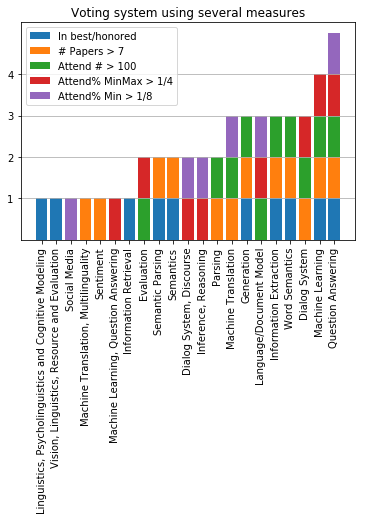

In [11]:
common_trends = set([
    t
    for top10 in top_10s.values()
    for t in top10
])
measures = list(top_10s.keys())

common_trends = [
    (t, [1 if t in top_10s[m] else 0 for m in measures])
    for t in common_trends
]
common_trends = sorted(common_trends, key=lambda x: sum(x[1]))

measure_topic = np.array([
    trend[1]
    for trend in common_trends
]).T


h = np.zeros_like(measure_topic[0])
for i,measure in enumerate(measures):
    plt.bar(
        x=range(len(common_trends)),
        height=measure_topic[i],
        bottom=h,
        label=measure,
    )
    h += measure_topic[i]


plt.xticks(range(len(common_trends)), [t for t, s in common_trends], rotation=90)
plt.yticks([1, 2, 3, 4,])
plt.grid(axis='y')
plt.legend()
plt.title('Voting system using several measures')
plt.savefig('summerized_measures.png',bbox_inches='tight')
plt.show()

#print("Measures include:", top_10s.keys())

### Conclusions
- *To highlight what we represent with this measure, a topic such as "Information Extraction" is a perfect example. It has highest number of oral presentations 5 session (20 talks) but with low attendance rate. But topics with much less papers and higher demand came up in this ranking.* 

- *The popularity of some topics is the result of the popularity of the certain papers in these sessions. E.g. the topics such as "Evaluation", "Language/Document Model" only had one session, which means they only had 4 oral presentations. But they got high attendance on certain papers:*

  1. (Evaluation) *[The Hitchhiker’s Guide to Testing Statistical Significance in Natural Language Processing](https://acl2018.org/paper/703)*. Rotem Dror, Gili Baumer, Segev Shlomov, Roi Reichart. 
  2. (Language/Document Model) *[What you can cram into a single \$&amp;!#&#42; vector: Probing sentence embeddings for linguistic properties](https://acl2018.org/paper/891)*. Alexis Conneau, Germán Kruszewski, Guillaume Lample, Loïc Barrault, Marco Baroni.
  
- *The most conclusive result is that "Question Answering" and "Dialog System" were the hotest topics. They were part of the top-10 most presented topics (out of 31 topics) and with all measures they persistantly had larg amount of attention.*

- Within the 


In [12]:
# what is not in that list?
for l in labels:
    if l not in set(t for t,_ in common_trends):
        print(l)

Argument Mining
Discourse
Generation, Summarization
Multilinguality
Multimodal
Parsing, Morphology
Resource, Annotation
Summarization
Text Mining and Applications
Vision


In [13]:
# This measure is more than anything correlates with the number of papers with high attendees in each topic
from scipy.stats import spearmanr

common_trends_ = Counter({t:sum(ms) for t,ms in common_trends})
for l in labels:
    common_trends_[l]+=0

count_liked_papers = Counter([
    [l for l in labels if p['session'] == l.lower()][0]
    for p in presentations
    if 'attendance_rate' in p and p['attendance_rate'] > 1/4
    if len([l for l in labels if p['session'] == l.lower()])
])
    
x_order = [s for t, s in common_trends_.most_common()]
x_count = [scores_count[t] for t, s in common_trends_.most_common()]
x_max = [scores_max[t] for t, s in common_trends_.most_common()]
x_min = [scores_min[t] for t, s in common_trends_.most_common()]
x_minmax = [scores_minmax[t] for t, s in common_trends_.most_common()]
x_avg = [scores_mean[t] for t, s in common_trends_.most_common()]
x_liked = [count_liked_papers[t] for t, s in common_trends_.most_common()]

print('Min', spearmanr(x_order, x_min).correlation)
print('MinMax', spearmanr(x_order, x_minmax).correlation)
print('Count', spearmanr(x_order, x_count).correlation)
print('Average', spearmanr(x_order, x_avg).correlation)
print('Max', spearmanr(x_order, x_max).correlation)
print('Liked papers', spearmanr(x_order, x_liked).correlation)


Min 0.19637176034098866
MinMax 0.33123448252226023
Count 0.6953397662886022
Average 0.7536935182611278
Max 0.8509442948109509
Liked papers 0.8616369752262262


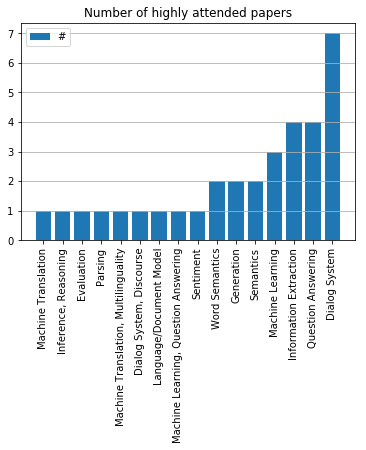

In [14]:
count_liked_papers = sorted(count_liked_papers.items(), key=lambda x: x[1])

plt.bar(
    x=range(len(count_liked_papers)),
    height=[s for t, s in count_liked_papers],
    label="#",
)
plt.xticks(range(len(count_liked_papers)), [t for t, s in count_liked_papers], rotation=90)
#plt.yticks([1, 2, 3, 4,])
plt.grid(axis='y')
plt.legend()
plt.title('Number of highly attended papers')
plt.savefig('highly_attended_papers.png',bbox_inches='tight')
plt.show()
